In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# prefix path
prefix = '/content/drive/MyDrive/데이터크리에이터캠프/CV/task2/jinwoo'

In [3]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
from keras.datasets import cifar10
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import os

In [4]:
# augmentation 함수
# 이후 lambda layer로 사용
def aug_fun(data):
  out = tf.image.random_brightness(data, 0.5)
  out = tf.image.random_saturation(out, 3, 10)

  return out

In [5]:
# dataset 로드
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

170508288/170498071 [==============================] - 2s 0us/step


In [6]:
# class 수
num_class = len(np.unique(y_train))

In [7]:
# valid dataset 생성
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, stratify=y_train, random_state=42)

In [8]:
# one-hot encoding
y_train = keras.utils.to_categorical(y_train)
y_val = keras.utils.to_categorical(y_val)
y_test = keras.utils.to_categorical(y_test)

In [9]:
# data shape
x_train.shape, x_val.shape, x_test.shape

((37500, 32, 32, 3), (12500, 32, 32, 3), (10000, 32, 32, 3))

In [10]:
# 전처리 함수
# normalizing
def normalizing(x_batch, y_batch):
  x_batch = tf.cast(x_batch, tf.float32)
  x_batch /= 255.0

  return x_batch, y_batch


def resizing(x_batch, y_batch):
  x_batch = tf.image.resize(x_batch, (71, 71))

  return x_batch, y_batch

In [11]:
# 데이터 셋 생성
batch_size = 512

train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = train_dataset.batch(batch_size)
train_dataset = train_dataset.map(normalizing).shuffle(1000, seed=42)
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

valid_dataset = tf.data.Dataset.from_tensor_slices((x_val, y_val))
valid_dataset = valid_dataset.batch(batch_size).map(normalizing)
valid_dataset = valid_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))
test_dataset = test_dataset.batch(batch_size).map(normalizing)
test_dataset = test_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [12]:
# augmentation 모델
# 명도, 채도 변경
# 회전, 반전
# 이미지 대비 변경
data_augmentation = keras.Sequential([
      keras.layers.Lambda(lambda x: aug_fun(x)),
      keras.layers.RandomRotation(0.2),
      keras.layers.RandomFlip(),
      keras.layers.RandomContrast(0.3)
])
# model
# data_augmentation 모델을 레이어처럼 추가
# input을 지정해 주어야 한다.
model = keras.models.Sequential([
            keras.layers.Input(shape=(32, 32, 3)),
            data_augmentation,
            keras.layers.Conv2D(16, 5, activation='relu'),
            keras.layers.BatchNormalization(),
            keras.layers.MaxPool2D(pool_size=(3, 3)),
            keras.layers.Conv2D(32, 3, activation='relu'),
            keras.layers.BatchNormalization(),
            keras.layers.MaxPool2D(pool_size=(2, 2)),
            keras.layers.Flatten(),
            keras.layers.Dense(120, activation='relu'),
            keras.layers.BatchNormalization(),
            keras.layers.Dense(62, activation='relu'),
            keras.layers.BatchNormalization(),
            keras.layers.Dense(20, activation='relu'),
            keras.layers.Dense(num_class, activation='softmax')
])

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics='accuracy'
)

In [24]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_6 (Sequential)    (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 28, 28, 16)        1216      
_________________________________________________________________
batch_normalization_8 (Batch (None, 28, 28, 16)        64        
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 9, 9, 16)          0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 7, 7, 32)          4640      
_________________________________________________________________
batch_normalization_9 (Batch (None, 7, 7, 32)          128       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 3, 3, 32)         

In [25]:
# callback method

# checkpoint path
ckpt_name = 'aug_in_CNN_ckpt.hdf5'
checkpoint_dir_path = os.path.join(prefix, 'checkpoint')
checkpoint_path = os.path.join(prefix, 'checkpoint', ckpt_name)

# check checkpoint paht
# 디렉토리가 존재하지 않으면 생성
if not(os.path.exists(checkpoint_dir_path)):
  os.mkdir(checkpoint_dir_path)

callbacks_list = [
    # accuracy 기준 가장 높은 모델의 weight 저장
    tf.keras.callbacks.ModelCheckpoint(
        filepath = checkpoint_path,
        monitor='val_accuracy',
        mode='max',
        save_weights_only=True,
        save_best_only=True
    ),
    # EarlyStopping
    tf.keras.callbacks.EarlyStopping(
        monitor='val_accuracy',
        mode='max',
        verbose=1, 
        patience=10
    )
]

In [26]:
hist = model.fit(train_dataset, validation_data=valid_dataset, callbacks=callbacks_list, epochs=100)

Epoch 1/100
74/74 [==============================] - 6s 57ms/step - loss: 2.1304 - accuracy: 0.2327 - val_loss: 2.2259 - val_accuracy: 0.1594
Epoch 2/100
74/74 [==============================] - 4s 54ms/step - loss: 1.8927 - accuracy: 0.3118 - val_loss: 2.2180 - val_accuracy: 0.1831
Epoch 3/100
74/74 [==============================] - 4s 54ms/step - loss: 1.7998 - accuracy: 0.3457 - val_loss: 2.2830 - val_accuracy: 0.2004
Epoch 4/100
74/74 [==============================] - 4s 54ms/step - loss: 1.7565 - accuracy: 0.3661 - val_loss: 2.2517 - val_accuracy: 0.2390
Epoch 5/100
74/74 [==============================] - 4s 55ms/step - loss: 1.7166 - accuracy: 0.3805 - val_loss: 2.2608 - val_accuracy: 0.2530
Epoch 6/100
74/74 [==============================] - 4s 54ms/step - loss: 1.6782 - accuracy: 0.3979 - val_loss: 2.0270 - val_accuracy: 0.2942
Epoch 7/100
74/74 [==============================] - 4s 54ms/step - loss: 1.6450 - accuracy: 0.4097 - val_loss: 1.9023 - val_accuracy: 0.3281
Epoch 

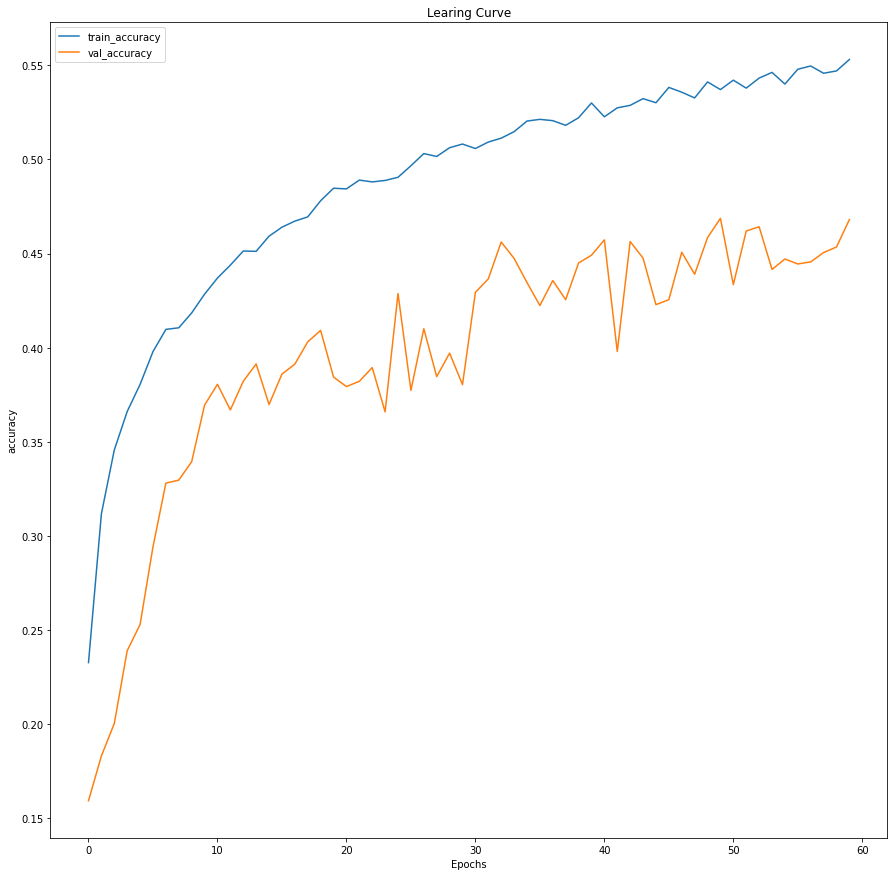

In [27]:
# learning curve
plt.figure(figsize=(15, 15))
plt.plot(hist.history['accuracy'], label='train_accuracy')
plt.plot(hist.history['val_accuracy'], label='val_accuracy')
plt.title('Learing Curve')
plt.xlabel('Epochs')
plt.ylabel('accuracy')
plt.legend()

In [28]:
# load last ckpt weight
model.load_weights(checkpoint_path)

In [29]:
# evaluate test set
model.evaluate(test_dataset)

20/20 [==============================] - 0s 14ms/step - loss: 1.5106 - accuracy: 0.4698


[1.510609745979309, 0.4697999954223633]

In [23]:
# Xception
with tf.device('gpu'):
  base = keras.applications.EfficientNetB0(input_shape=(32, 32, 3), weights=None, include_top=False)

  # make top
  effi = keras.models.Sequential()
  effi.add(keras.layers.Input(shape=(32, 32, 3)))
  effi.add(data_augmentation)
  effi.add(base)
  effi.add(keras.layers.GlobalAveragePooling2D())
  effi.add(keras.layers.BatchNormalization())
  effi.add(keras.layers.Dense(num_class, activation='softmax'))

  xception.compile(
      optimizer='adam',
      loss='categorical_crossentropy',
      metrics='accuracy'
  )

In [25]:
effi.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, None, None, 3)     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, 1, 1, 1280)        4049571   
_________________________________________________________________
global_average_pooling2d_2 ( (None, 1280)              0         
_________________________________________________________________
batch_normalization_12 (Batc (None, 1280)              5120      
_________________________________________________________________
dense_6 (Dense)              (None, 10)                12810     
Total params: 4,067,501
Trainable params: 4,022,918
Non-trainable params: 44,583
_________________________________________________________________


In [26]:
# callback method

# checkpoint path
ckpt_name = 'aug_in_effi_ckpt.hdf5'
checkpoint_dir_path = os.path.join(prefix, 'checkpoint')
checkpoint_path = os.path.join(prefix, 'checkpoint', ckpt_name)

# check checkpoint paht
# 디렉토리가 존재하지 않으면 생성
if not(os.path.exists(checkpoint_dir_path)):
  os.mkdir(checkpoint_dir_path)

callbacks_list = [
    # accuracy 기준 가장 높은 모델의 weight 저장
    tf.keras.callbacks.ModelCheckpoint(
        filepath = checkpoint_path,
        monitor='val_accuracy',
        mode='max',
        save_weights_only=True,
        save_best_only=True
    ),
    # EarlyStopping
    tf.keras.callbacks.EarlyStopping(
        monitor='val_accuracy',
        mode='max',
        verbose=1, 
        patience=10
    )
]

In [27]:
hist = effi.fit(train_dataset, validation_data=valid_dataset, callbacks=callbacks_list, epochs=100)

Epoch 1/100
74/74 [==============================] - 36s 302ms/step - loss: 2.5170 - accuracy: 0.1627 - val_loss: 2.3087 - val_accuracy: 0.1000
Epoch 2/100
74/74 [==============================] - 19s 254ms/step - loss: 2.2627 - accuracy: 0.2021 - val_loss: 2.3156 - val_accuracy: 0.1000
Epoch 3/100
74/74 [==============================] - 19s 254ms/step - loss: 2.1184 - accuracy: 0.2238 - val_loss: 2.3240 - val_accuracy: 0.1000
Epoch 4/100
74/74 [==============================] - 19s 253ms/step - loss: 2.0803 - accuracy: 0.2414 - val_loss: 2.3213 - val_accuracy: 0.1000
Epoch 5/100
74/74 [==============================] - 19s 252ms/step - loss: 2.0300 - accuracy: 0.2574 - val_loss: 2.3171 - val_accuracy: 0.1000
Epoch 6/100
74/74 [==============================] - 19s 252ms/step - loss: 2.0064 - accuracy: 0.2683 - val_loss: 2.3503 - val_accuracy: 0.1000
Epoch 7/100
74/74 [==============================] - 19s 253ms/step - loss: 1.9756 - accuracy: 0.2795 - val_loss: 2.3054 - val_accuracy:

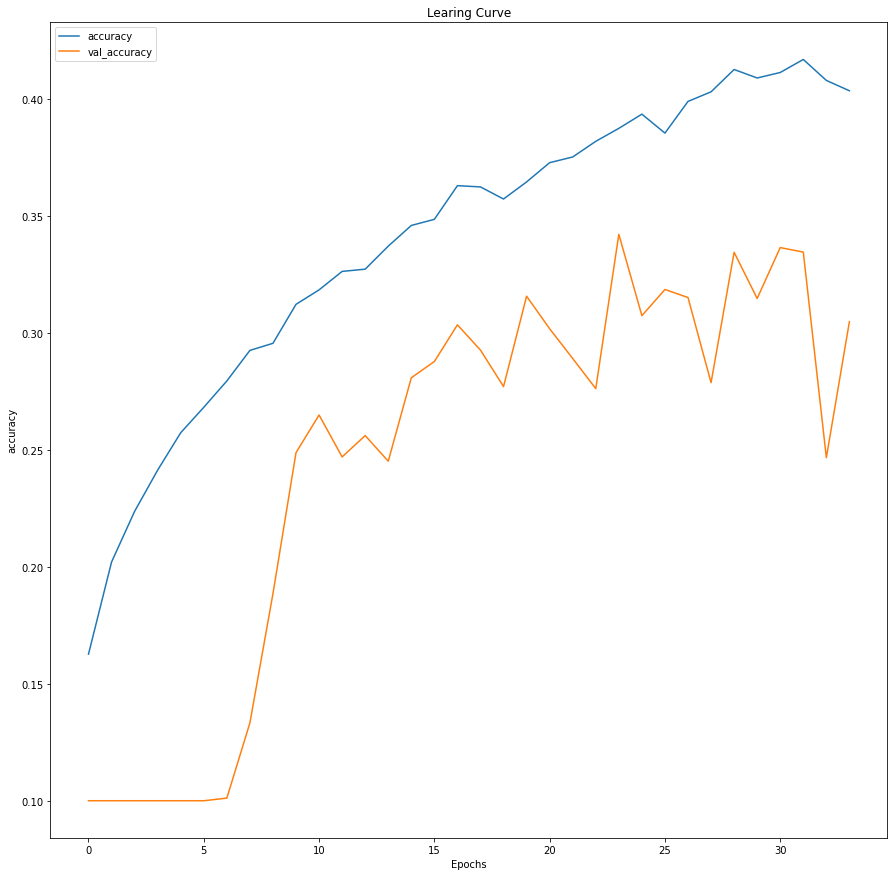

In [28]:
# learning curve
plt.figure(figsize=(15, 15))
plt.plot(hist.history['accuracy'], label='accuracy')
plt.plot(hist.history['val_accuracy'], label='val_accuracy')
plt.title('Learing Curve')
plt.xlabel('Epochs')
plt.ylabel('accuracy')
plt.legend()

In [29]:
# load last ckpt weight
effi.load_weights(checkpoint_path)

In [30]:
# evaluate test set
effi.evaluate(test_dataset)

20/20 [==============================] - 3s 157ms/step - loss: 2.1461 - accuracy: 0.2924


[2.146077871322632, 0.2924000024795532]